In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Dataset 1
## Load the dataset into pandas dataframe

In [2]:
# Load the dataset
data = pd.read_csv('./data_set_1.csv', header = None)

In [3]:
data = data.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")

In [4]:
data.head()

,Index,X1,X2
0,1,0.719791,0.317260
1,2,0.718572,0.308538
2,3,0.717821,0.303025
3,4,0.725701,0.363205
4,5,0.724039,0.350726


## Applying K-means Clustering to form clusters and then sample data points from each cluster. 
## Originally started with 50 clusters ut, data sampled doesn't cover outliers or points on the border. After experimenting, settled with 2500 clusters for even distribution of clusters and sampled 1 point from each cluster. 
## Also, applied DBSCAN clustering for comparison and found that selected samples from DBSCAN are not as good as kmeans with 2500 clusters. Specifically, DBSCAN is failing to cover the outliers or boundary pixels. I put the DBSCAN results below for comparison

In [5]:
# Assume columns 'X1', 'X2', and 'Y' for Frequency, Power, and Vibration Level
# Only 'X1' and 'X2' will be used for sampling

# Step 1: Use K-Means to find high-density clusters in the normalized data
num_clusters = 2500  # Start with 50 clusters for density regions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['X1', 'X2']])

# Step 2: Uniformly sample data within each cluster
sampled_data = pd.DataFrame()
samples_per_cluster = 2500 // num_clusters  # Number of samples per cluster

for cluster in range(num_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    if len(cluster_data) > samples_per_cluster:
        # Randomly sample within the cluster
        cluster_sample = cluster_data.sample(n=samples_per_cluster, random_state=42)
    else:
        # Take all if fewer samples than needed
        cluster_sample = cluster_data
    sampled_data = pd.concat([sampled_data, cluster_sample])

# Step 3: Add additional samples from high-density regions if fewer than 2500 samples
if len(sampled_data) < 2500:
    remaining_needed = 2500 - len(sampled_data)
    additional_samples = data.sample(n=remaining_needed, random_state=42)
    sampled_data = pd.concat([sampled_data, additional_samples])

## Save the sampled dataset to a CSV

In [6]:
# Reset index of the final sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

# Save the sampled dataset
sampled_data.to_csv('sampled_data_set_1_kmeans_2500.csv', index=False)

## Visualization showing original dataset vs sampled dataset.
### Observations
* Sampled dataset covers all the outliers or boundary cases in the original dataset
* We can also notice that coverage is even

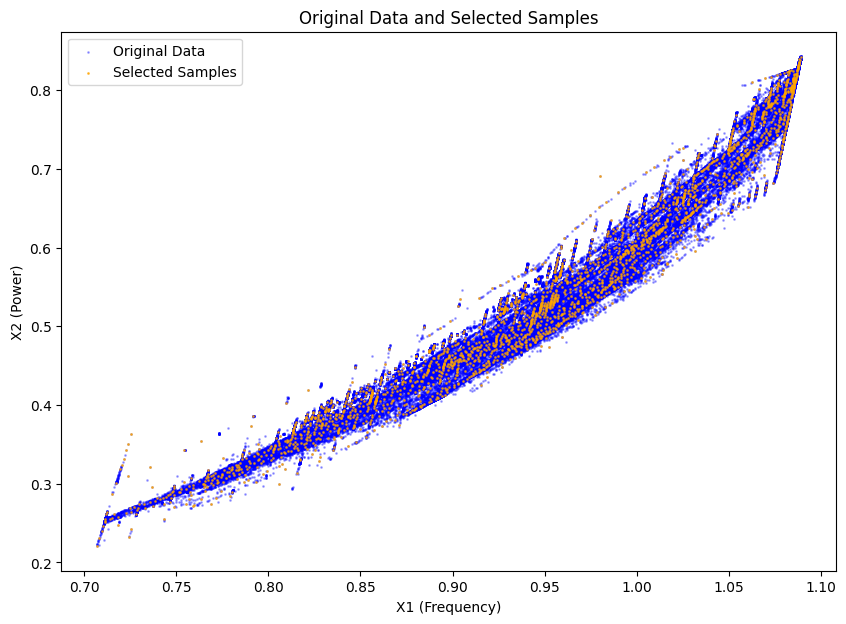

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original and sampled data
original_data = pd.read_csv('data_set_1.csv', header = None)
original_data = original_data.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")
sampled_data = pd.read_csv('sampled_data_set_1_kmeans_2500.csv')

# Plot original data in blue
plt.figure(figsize=(10, 7))
plt.scatter(original_data['X1'], original_data['X2'], color='blue', label='Original Data', alpha=0.3, s=1)

# Plot sampled data in orange
plt.scatter(sampled_data['X1'], sampled_data['X2'], color='orange', label='Selected Samples', alpha=0.7, s=1)

# Add labels and title
plt.xlabel('X1 (Frequency)')
plt.ylabel('X2 (Power)')
plt.title('Original Data and Selected Samples')
plt.legend()
plt.savefig('original_vs_selected_kmeans_2500.png')
plt.show()

## Visualization showing data density in original data vs sampled data.
### Observations:
* We can identify that there are common high density regions
* Sampled data spread the density a bit more evenly while also maintaining the same density peaks as in original dataset

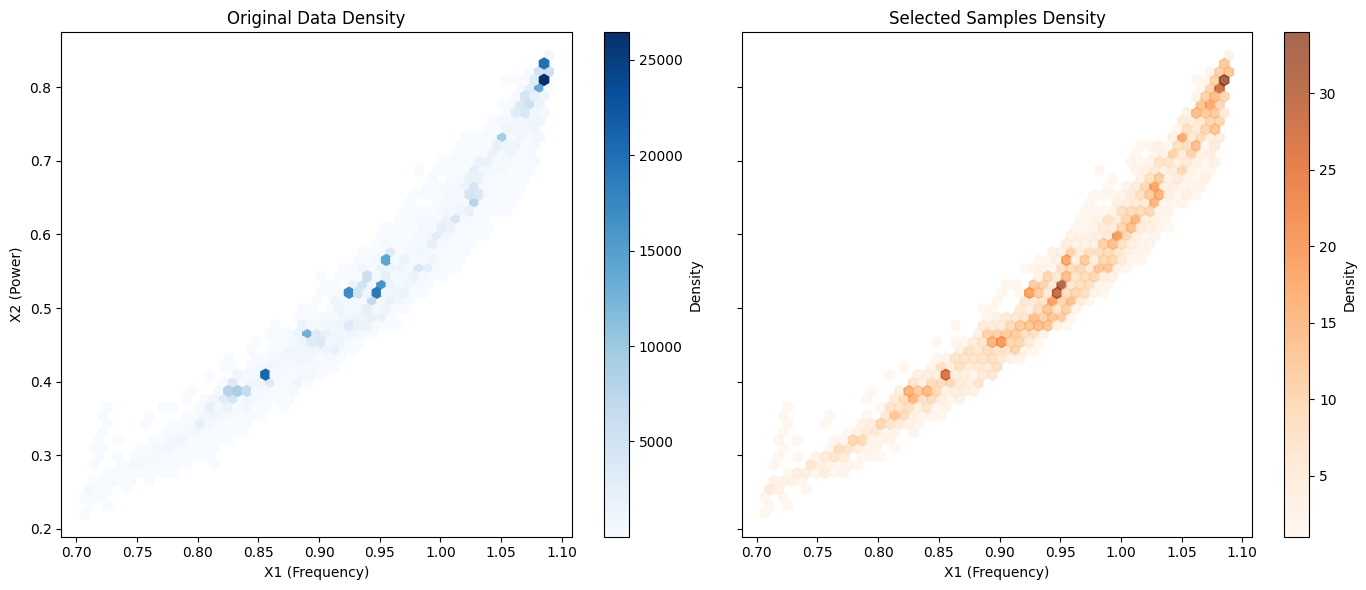

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original and sampled data
original_data = pd.read_csv('data_set_1.csv', header=None)
original_data = original_data.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")
sampled_data = pd.read_csv('sampled_data_set_1_kmeans_2500.csv')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot the density of original data
hb_original = ax1.hexbin(original_data['X1'], original_data['X2'], gridsize=50, cmap='Blues', mincnt=1)
ax1.set_xlabel('X1 (Frequency)')
ax1.set_ylabel('X2 (Power)')
ax1.set_title('Original Data Density')
cbar1 = fig.colorbar(hb_original, ax=ax1, label='Density')

# Plot the density of selected samples
hb_sampled = ax2.hexbin(sampled_data['X1'], sampled_data['X2'], gridsize=50, cmap='Oranges', mincnt=1, alpha=0.7)
ax2.set_xlabel('X1 (Frequency)')
ax2.set_title('Selected Samples Density')
cbar2 = fig.colorbar(hb_sampled, ax=ax2, label='Density')

# Show the plot
plt.tight_layout()
plt.show()

## DBSCAN results (Only for comparison)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# Load the dataset
data = pd.read_csv('./data_set_1.csv', header=None)
data = data.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")

# Step 1: Apply DBSCAN to find dense regions in the data
eps = 0.05  # Max distance between two samples for them to be considered as in the same neighborhood
min_samples = 10  # Minimum number of samples in a neighborhood to form a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
data['Cluster'] = dbscan.fit_predict(data[['X1', 'X2']])

# Step 2: Uniformly sample data from the identified clusters
sampled_data = pd.DataFrame()
samples_per_cluster = 2500  # Number of total samples to select

# Identify the unique clusters (excluding noise labeled as -1)
clusters = data['Cluster'].unique()
clusters = clusters[clusters != -1]  # Exclude noise cluster (-1)

# Step 3: Randomly sample from each identified cluster
for cluster in clusters:
    cluster_data = data[data['Cluster'] == cluster]
    # Determine the number of samples to take from each cluster
    cluster_sample_size = min(len(cluster_data), samples_per_cluster // len(clusters))
    cluster_sample = cluster_data.sample(n=cluster_sample_size, random_state=42)
    sampled_data = pd.concat([sampled_data, cluster_sample])

# Step 4: If the total sampled data is less than 2500, add additional random samples
if len(sampled_data) < 2500:
    remaining_needed = 2500 - len(sampled_data)
    additional_samples = data.sample(n=remaining_needed, random_state=42)
    sampled_data = pd.concat([sampled_data, additional_samples])

# Reset index of the final sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

# Save the sampled dataset
sampled_data.to_csv('sampled_data_set_1_dbscan_2500.csv', index=False)


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# Define the chunk size to load the data in smaller parts
chunk_size = 100000  # Process data in chunks of 100,000 rows at a time

# Define DBSCAN parameters
eps = 0.05  # Max distance between two samples for them to be considered in the same neighborhood
min_samples = 10  # Minimum number of samples in a neighborhood to form a cluster

# Initialize an empty list to store sampled data
sampled_data = []

# Initialize DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Function to process and sample data in chunks
def process_chunk(chunk):
    # Apply DBSCAN clustering on the chunk
    chunk['Cluster'] = dbscan.fit_predict(chunk[['X1', 'X2']])
    
    # Identify clusters (excluding noise, which is labeled as -1)
    clusters = chunk['Cluster'].unique()
    clusters = clusters[clusters != -1]  # Exclude noise points
    
    # Sampling from each cluster
    for cluster in clusters:
        cluster_data = chunk[chunk['Cluster'] == cluster]
        # Determine how many samples to take
        cluster_sample_size = min(len(cluster_data), 2500 // len(clusters))
        sampled_data.append(cluster_data.sample(n=cluster_sample_size, random_state=42))

# Load and process the data in chunks
for chunk in pd.read_csv('./data_set_1.csv', header=None, chunksize=chunk_size):
    chunk = chunk.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")
    process_chunk(chunk)

# Concatenate the list of sampled data and ensure total samples are <= 2500
sampled_data = pd.concat(sampled_data)

# If the sampled data is less than 2500, add random additional samples
if len(sampled_data) < 2500:
    remaining_needed = 2500 - len(sampled_data)
    additional_samples = pd.read_csv('./data_set_1.csv', header=None).sample(n=remaining_needed, random_state=42)
    sampled_data = pd.concat([sampled_data, additional_samples])

# Reset index and save the final sampled dataset
sampled_data = sampled_data.reset_index(drop=True)
sampled_data.to_csv('sampled_data_set_1_dbscan_2500.csv', index=False)

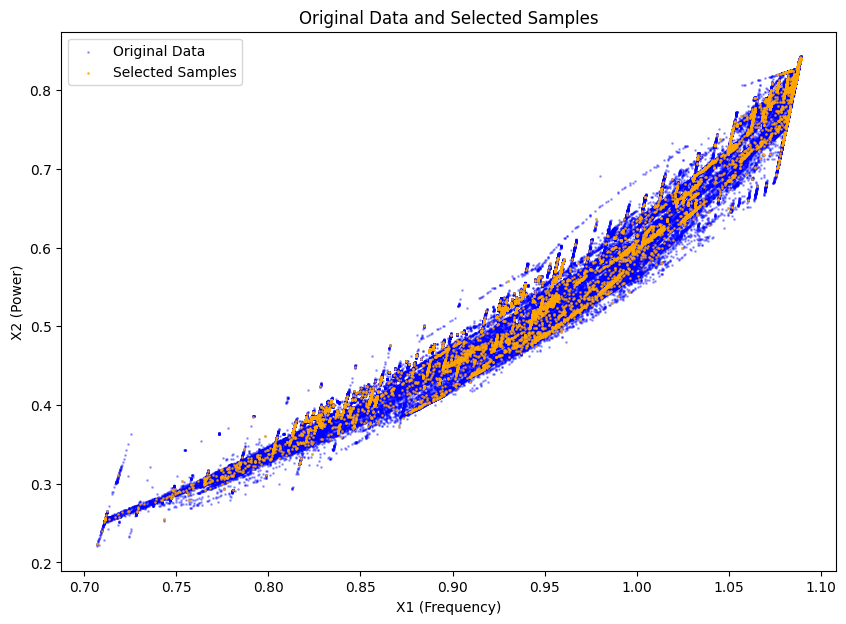

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original and sampled data
original_data = pd.read_csv('data_set_1.csv', header = None)
original_data = original_data.rename(columns={0: "Index", 1: "X1", 2: "X2"}, errors="raise")
sampled_data = pd.read_csv('sampled_data_set_1_dbscan_2500.csv')

# Plot original data in blue
plt.figure(figsize=(10, 7))
plt.scatter(original_data['X1'], original_data['X2'], color='blue', label='Original Data', alpha=0.3, s=1)

# Plot sampled data in orange
plt.scatter(sampled_data['X1'], sampled_data['X2'], color='orange', label='Selected Samples', alpha=0.7, s=1)

# Add labels and title
plt.xlabel('X1 (Frequency)')
plt.ylabel('X2 (Power)')
plt.title('Original Data and Selected Samples')
plt.legend()
plt.savefig('original_vs_selected_kmeans_2500.png')
plt.show()